Discard: Not clear what this is

In [93]:
import torch
import numpy as npd
import pylab as plt
import numpy as np

In [121]:
SIGMA = 0.01
N = 10001

kernel = torch.tensor([0.1, 0.3, 0.5, 0.9, 1.0, 0.9, 0.5, 0.3, 0.1]).unsqueeze(0).unsqueeze(0)


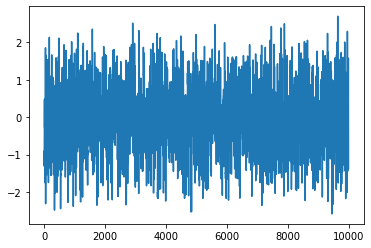

In [122]:
def model(u):
    alpha = torch.exp(u[:, -1]*2-1).detach()
    v = torch.distributions.Normal(0., 1.).icdf(u[:, :-1])
    v = torch.nn.functional.conv1d(v.unsqueeze(1), kernel, None, padding=4).squeeze(1)
    return v*alpha.unsqueeze(1)

def log_prob(obs, pred):
    return (-(obs-pred)**2/SIGMA**2).sum(axis=1)-0.5*N*np.log(np.pi*2)-N*np.log(SIGMA)

def draw(pred):
    return pred + torch.randn(pred.size())*SIGMA

u0 = torch.rand(1, N)
x0 = draw(model(u0))[0]
plt.plot(x0)

In [123]:
K = 300
u = torch.rand(K, N)
u[:,-1] = 0.9

In [124]:
for _ in range(100):
    u.requires_grad = True
    z = model(u)
    loss = -log_prob(x0, z)
    th = 10*np.sqrt(N)# + 1000000000
    loss = torch.where(loss > th, loss, loss*0.+th)
    sum(loss).backward()
    epsilon = 1e-3
    u_grad = torch.where(torch.abs(u.grad) < 1e-2/epsilon, u.grad, 1e-2/epsilon*torch.sign(u.grad))
    up = u - epsilon * u_grad
    w = 0.01
    up[:,:-1] = up[:,:-1] + torch.randn(u[:,:-1].size())*w
    u = u.detach()
    up = up.detach()
    u = torch.where(up > 0., torch.where(up < 1., up, u), u)
print(th)

1000.0499987500625


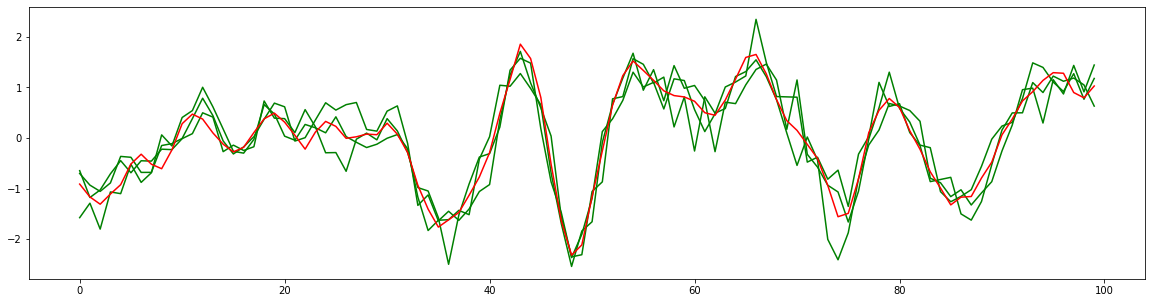

In [128]:
plt.figure(figsize=(20, 5))
v = model(u).numpy()
for i in range(3):
    #if(u[i,-1] < 0.2):
        plt.plot(v[i][:100], color="g")
    #if(u[i,-1] > 0.65):
    #    plt.plot(v[i][:100], color="r")
plt.plot(x0[:100], color='r')

(0.0, 1.0)

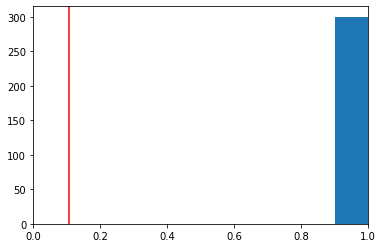

In [126]:
plt.hist(u[:,-1].numpy())
plt.axvline(u0[0,-1], color='r')
plt.xlim([0,1])

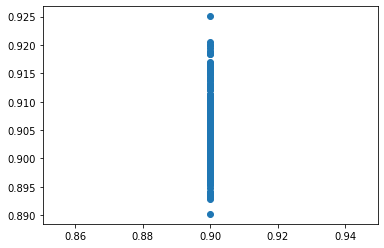

In [127]:
stds = [np.std(v[i,:]) for i in range(len(u))]
alphas = u[:,-1].numpy()
plt.scatter(alphas, stds)